# Importation des Bibliothèques
Importer les bibliothèques nécessaires : numpy, matplotlib, solver_npuzzle, npuzzle, time, etc.

In [2]:
# Importation des Bibliothèques

import numpy as np
import matplotlib.pyplot as plt
import time
from solver_npuzzle import solve_bfs, solve_dfs, solve_astar
from npuzzle import create_goal, shuffle, to_string, is_solution, load_puzzle
from node import Node
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time
import os
import subprocess

# Définition des Fonctions Utilitaires
Créer une fonction run_with_timeout pour limiter le temps d'exécution des algorithmes et une fonction pour générer des puzzles de différentes tailles.

In [3]:
# Définition des Fonctions Utilitaires

import signal
from contextlib import contextmanager

# Fonction pour gérer le timeout
class TimeoutException(Exception):
    pass

@contextmanager
def run_with_timeout(seconds):
    def signal_handler(signum, frame):
        raise TimeoutException("Timed out!")
    signal.signal(signal.SIGALRM, signal_handler)
    signal.alarm(seconds)
    try:
        yield
    finally:
        signal.alarm(0)

# Génération des Puzzles
Générer des puzzles de tailles différentes (4x4, 5x5, etc.) avec différentes longueurs de séquences de mouvements.

In [4]:

def check_existing_puzzles(size, max_length):
    """Vérifie si tous les puzzles nécessaires existent déjà"""
    dir_path = f"puzzles/{size}x{size}"
    if not os.path.exists(dir_path):
        return False
        
    files = os.listdir(dir_path)
    required_files = {f"npuzzle_{size}x{size}_len{i}_0.txt" for i in range(1, max_length + 1)}
    existing_files = set(files)
    
    return required_files.issubset(existing_files)

def create_puzzle_directories(sizes):
    """Crée les dossiers pour les puzzles si nécessaire"""
    for size in sizes:
        dir_path = f"puzzles/{size}x{size}"
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
            print(f"Dossier créé : {dir_path}")

def generate_all_puzzles(sizes, max_length, num_puzzles=1):
    """Génère les puzzles manquants pour chaque taille"""
    for size in sizes:
        if not check_existing_puzzles(size, max_length):
            print(f"\nGénération des puzzles {size}x{size}...")
            cmd = [
                "python3", 
                "generate_npuzzle.py",
                "-s", str(size),
                "-ml", str(max_length),
                "-n", str(num_puzzles),
                f"puzzles/{size}x{size}",
                "-v",
            ]
            
            with open(os.devnull, 'w') as f:
                subprocess.run(cmd, stdout=f)
        else:
            print(f"\nLes puzzles {size}x{size} existent déjà")

# Paramètres de génération
tailles = [4, 5]  # Tailles des puzzles (4x4, 5x5, etc.)
nombre_puzzles = 10  # Nombre de puzzles à générer pour chaque taille
longueur_max = 50 # Longueur maximale de la séquence de mouvements

# Création des dossiers pour les puzzles
create_puzzle_directories(tailles)
generate_all_puzzles(tailles, longueur_max, nombre_puzzles)


Les puzzles 4x4 existent déjà

Les puzzles 5x5 existent déjà


# Mesure des Performances
Mesurer le temps d'exécution de chaque algorithme (BFS, DFS, A*) sur les puzzles générés avec un timeout.

In [5]:
# Mesure des Performances

# Fonction pour mesurer le temps d'exécution d'un algorithme avec timeout
import sys


def measure_time(algorithm, puzzle, timeout):
    start_time = time.time()
    try:
        with run_with_timeout(timeout):
            if algorithm.__name__ == 'solve_astar':
                solution = algorithm([Node(state=puzzle, move=None)], [])
            else:
                solution = algorithm([Node(state=puzzle, move=None)])
            duration = time.time() - start_time
            return duration, is_solution(puzzle, solution)
    except TimeoutException:
        return timeout, False

def load_puzzles_by_length(sizes, max_length):
    """Charge les puzzles générés dans l'ordre de leur longueur"""
    puzzles_by_size = {}
    
    for size in sizes:
        puzzles_by_size[size] = []
        dir_path = f"puzzles/{size}x{size}"
        
        # Pour chaque longueur de 1 à max_length
        for length in range(1, max_length + 1):
            filename = f"npuzzle_{size}x{size}_len{length}_0.txt"
            file_path = f"{dir_path}/{filename}"
            
            try:
                puzzle = load_puzzle(file_path)
                puzzles_by_size[size].append(puzzle)
            except FileNotFoundError:
                print(f"Attention : {filename} non trouvé")
                break
    
    return puzzles_by_size

# Chargement des puzzles dans l'ordre
puzzles_par_taille = load_puzzles_by_length(tailles, longueur_max)

# Mesure des performances
timeout = 50  # Timeout en secondes
algorithms = {
    'BFS': solve_bfs,
    # 'DFS': solve_dfs,
    'A*': solve_astar
}

# Initialisation des résultats
results = {taille: {algo: [] for algo in algorithms} for taille in tailles}

tests_effectues = 0
tests_evites = 0
total_tests = sum(len(puzzles_par_taille[taille]) * len(algorithms) for taille in tailles)

def afficher_progression():
    total_restant = total_tests - tests_evites
    if total_restant <= 0:
        pourcentage = 100
    else:
        pourcentage = min((tests_effectues / total_restant) * 100, 100)
    
    barre = "█" * int(pourcentage / 2)
    spaces = " " * (50 - int(pourcentage / 2))
    
    clear_output(wait=True)
    print(f"Progression : |{barre}{spaces}| {pourcentage:.1f}%")
    print(f"Tests effectués : {tests_effectues}/{total_restant}")
    print(f"Tests restants : {max(0, total_restant - tests_effectues)}")
    if tests_evites > 0:
        print(f"Tests évités : {tests_evites}")

algo_timeouts = {algo: False for algo in algorithms}

for taille in tailles:
    puzzles = puzzles_par_taille[taille]
    for i, puzzle in enumerate(puzzles, 1):
        for algo_name, algo_func in algorithms.items():
            # Si cet algo a déjà eu un timeout sur cette taille
            if algo_timeouts[algo_name]:
                tests_evites += 1
                results[taille][algo_name].append(timeout)
                continue
                
            duration, solved = measure_time(algo_func, puzzle, timeout)
            tests_effectues += 1
            
            if duration >= timeout:
                # Marquer cet algorithme comme ayant un timeout
                algo_timeouts[algo_name] = True
                # Calculer les tests qui seront évités pour cet algo
                puzzles_restants = len(puzzles) - (i + 1)
                tests_evites += puzzles_restants
                
            results[taille][algo_name].append(duration)
            afficher_progression()
            
    # Réinitialiser les timeouts pour la prochaine taille
    algo_timeouts = {algo: False for algo in algorithms}


print("\nTests terminés !")

Progression : |██████████████████████████████████████████████████| 100.0%
Tests effectués : 166/134
Tests restants : 0
Tests évités : 66

Tests terminés !


# Création des Graphiques
Utiliser matplotlib pour créer des graphiques comparatifs montrant le temps d'exécution en fonction de la taille du puzzle pour chaque algorithme.

Tailles disponibles: [4, 5]

Structure de results:

Taille 4x4:
  BFS: 50 résultats
  A*: 50 résultats

Taille 5x5:
  BFS: 50 résultats
  A*: 50 résultats


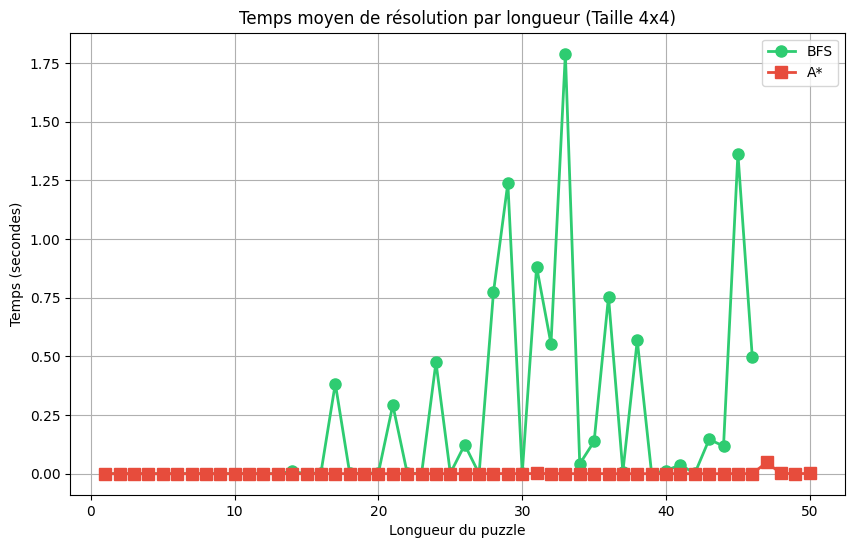

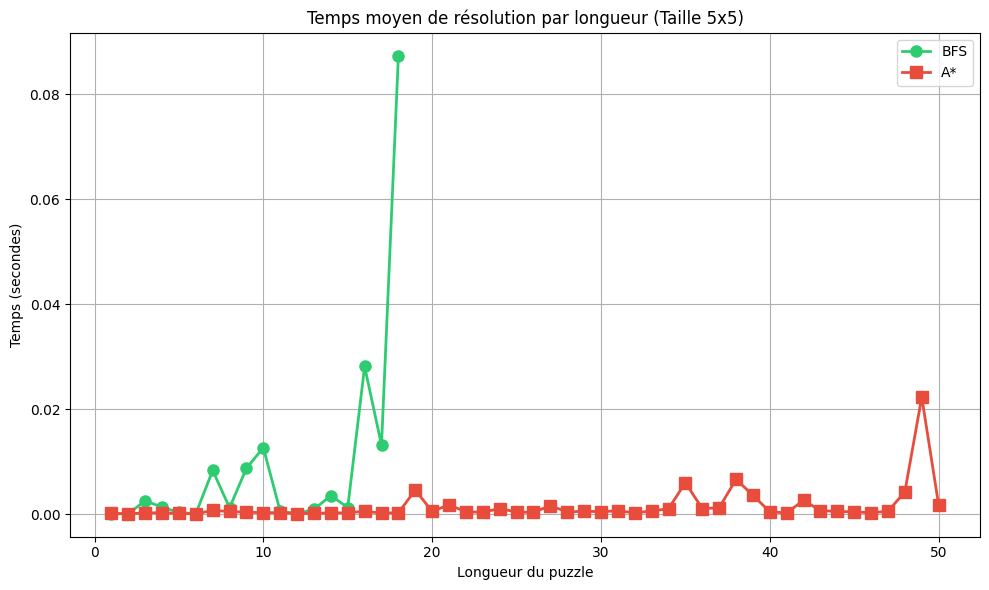


Statistiques détaillées :

Taille 4x4 :
------------------------------

BFS :
  • Taux de réussite : 92.0% (46/50)
  • Temps moyen : 0.222 secondes
  • Temps minimum : 0.000 secondes
  • Temps maximum : 1.789 secondes
  • Nombre de timeouts : 4

A* :
  • Taux de réussite : 100.0% (50/50)
  • Temps moyen : 0.001 secondes
  • Temps minimum : 0.000 secondes
  • Temps maximum : 0.048 secondes
  • Nombre de timeouts : 0

Taille 5x5 :
------------------------------

BFS :
  • Taux de réussite : 36.0% (18/50)
  • Temps moyen : 0.009 secondes
  • Temps minimum : 0.000 secondes
  • Temps maximum : 0.087 secondes
  • Nombre de timeouts : 32

A* :
  • Taux de réussite : 100.0% (50/50)
  • Temps moyen : 0.001 secondes
  • Temps minimum : 0.000 secondes
  • Temps maximum : 0.022 secondes
  • Nombre de timeouts : 0


In [6]:
# D'abord, vérifions les données disponibles
print("Tailles disponibles:", list(results.keys()))
print("\nStructure de results:")
for taille in results:
    print(f"\nTaille {taille}x{taille}:")
    for algo in results[taille]:
        print(f"  {algo}: {len(results[taille][algo])} résultats")

# Configuration du style des graphiques
colors = ['#2ecc71', '#e74c3c', '#3498db']
markers = ['o', 's', '^']

# Création d'une figure pour chaque taille disponible
for taille in sorted(results.keys()):  # On trie les tailles pour l'ordre
    plt.figure(figsize=(10, 6))
    
    # Pour chaque algorithme
    for idx, (algo_name, color, marker) in enumerate(zip(algorithms.keys(), colors, markers)):
        # Récupérer les résultats pour cette taille et cet algorithme
        resultats = results[taille][algo_name]
        
        # Calculer les temps moyens par longueur
        temps_moyens = []
        longueurs = []
        
        for i, temps in enumerate(resultats, 1):
            if temps < timeout:  # On exclut les timeouts
                temps_moyens.append(temps)
                longueurs.append(i)
        
        if temps_moyens:  # On trace seulement s'il y a des données
            plt.plot(longueurs, temps_moyens, color=color, marker=marker,
                    label=algo_name, linewidth=2, markersize=8)
    
    plt.title(f'Temps moyen de résolution par longueur (Taille {taille}x{taille})')
    plt.xlabel('Longueur du puzzle')
    plt.ylabel('Temps (secondes)')
    plt.legend()
    plt.grid(True)
    
plt.tight_layout()
plt.show()

# Ajout d'analyses statistiques détaillées
print("\nStatistiques détaillées :")
print("=" * 50)

# Pour chaque taille de puzzle
for taille in sorted(results.keys()):
    print(f"\nTaille {taille}x{taille} :")
    print("-" * 30)
    
    # Pour chaque algorithme
    for algo_name in algorithms:
        resultats = results[taille][algo_name]
        
        # Calcul des statistiques
        nb_total = len(resultats)
        nb_timeout = sum(1 for t in resultats if t >= timeout)
        nb_succes = nb_total - nb_timeout
        
        # Temps moyens (en excluant les timeouts)
        temps_valides = [t for t in resultats if t < timeout]
        temps_moyen = sum(temps_valides) / len(temps_valides) if temps_valides else float('inf')
        
        # Calcul des temps min/max (hors timeouts)
        temps_min = min(temps_valides) if temps_valides else float('inf')
        temps_max = max(temps_valides) if temps_valides else float('inf')
        
        print(f"\n{algo_name} :")
        print(f"  • Taux de réussite : {(nb_succes/nb_total)*100:.1f}% ({nb_succes}/{nb_total})")
        print(f"  • Temps moyen : {temps_moyen:.3f} secondes")
        print(f"  • Temps minimum : {temps_min:.3f} secondes")
        print(f"  • Temps maximum : {temps_max:.3f} secondes")
        print(f"  • Nombre de timeouts : {nb_timeout}")
        